# 0.0 IMPORTS

In [122]:
import math
import pandas as pd
import numpy as np
import inflection
import datetime
import seaborn as sns
from scipy import stats
from tabulate import tabulate
from matplotlib import pyplot as plt
from IPython.display import Image

## 0.1 Helper Functions:

In [160]:
def cramer_v( x, y): #correlação entre variáveis categóricas: V de Cramer
    cm = pd.crosstab(x, y).values             #tabela de contingência
    n = cm.sum()                              # n = número total de observações
    r, k = cm.shape                           # r = número de linhas, k = número de colunas
    
    chi2 = stats.chi2_contingency( cm )[0]                  #calculando o qui quadrado de Peason a partir de uma tabela de contingência
    chi2corr = max( 0, chi2 - (k - 1)*(r - 1) / (n - 1) )   #corrigindo o viés do V de Cramer
    kcorr = k - ((k - 1)**2) / (n - 1) 
    rcorr = r - ((r - 1)**2) / (n - 1)
    
    return np.sqrt( (chi2corr/n) / (min(kcorr - 1, rcorr - 1  ) ) )

## 0.2 Loading Data:

In [2]:
df_sales_raw = pd.read_csv('data/train.csv.zip', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

In [3]:
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df_raw.copy()

## 1.1 Rename Columns:

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename:
df1.columns = cols_new

## 1.2 Data Dimensions:

In [6]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types:

In [7]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [8]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA:

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA:

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if pd.isna(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] = (df1.apply(lambda x: x['date'].month if pd.isna(x['competition_open_since_month']) 
                                                 else x['competition_open_since_month'], axis = 1))

#competition_open_since_year     
df1['competition_open_since_year'] = (df1.apply(lambda x: x['date'].year if pd.isna(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis = 1))

#promo2_since_week    
df1['promo2_since_week'] = (df1.apply(lambda x: x['date'].week if pd.isna(x['promo2_since_week']) 
                                                 else x['promo2_since_week'], axis = 1))

#promo2_since_year   
df1['promo2_since_year'] = (df1.apply(lambda x: x['date'].year if pd.isna(x['promo2_since_year']) 
                                                 else x['promo2_since_year'], axis = 1))

In [12]:
#promo_interval     
month_map = {1: 'Jan', 2:'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']= (df1[['promo_interval', 'month_map']].apply(lambda x: 0 
                                                             if x['promo_interval'] == 0 else 1 
                                                             if x['month_map'] in x['promo_interval'].split(',') 
                                                             else 0, axis = 1))

In [13]:
df1.sample(5).T

,220430,645905,648977,384976,163395
store,776,1106,833,1034,606
day_of_week,4,6,3,6,6
date,2015-01-15 00:00:00,2013-11-30 00:00:00,2013-11-27 00:00:00,2014-07-26 00:00:00,2015-03-07 00:00:00
sales,4196,4028,4950,2478,4290
customers,493,459,461,260,441
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,a,d,a,a


In [14]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical 

In [17]:
num_attributes = df1.select_dtypes(include = ['int64', 'float'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\samso\AppData\Local\Temp\ipykernel_15180\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<Axes: xlabel='sales', ylabel='Density'>

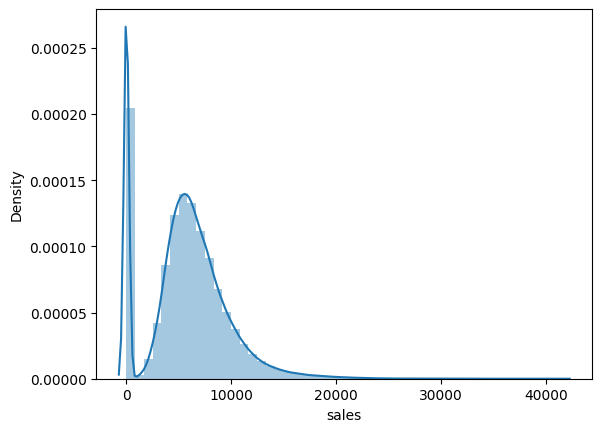

In [19]:
sns.distplot(df1['sales'])

### 1.7.2 Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

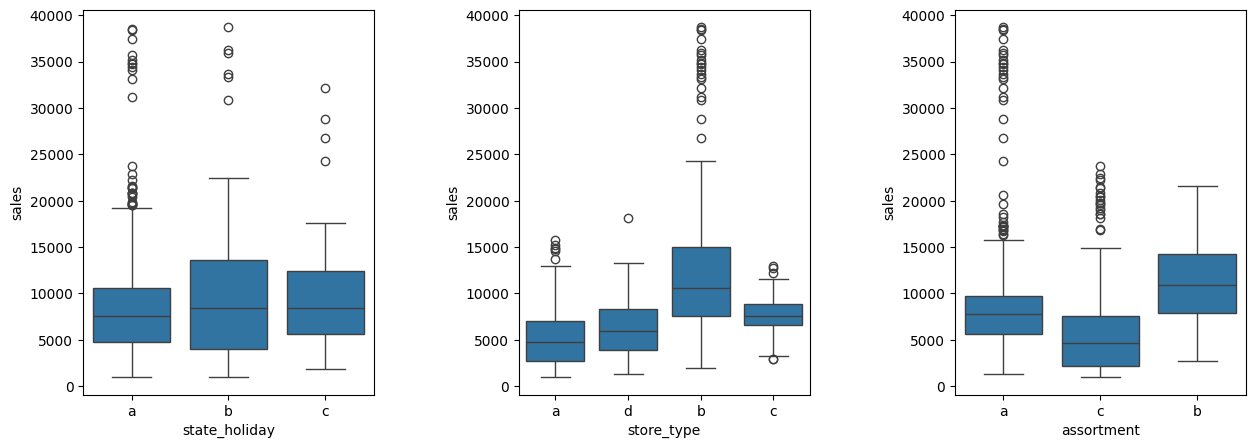

In [21]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot( x = 'store_type', y = 'sales', data = aux1)

plt.subplot(1,3,3)
sns.boxplot( x = 'assortment', y = 'sales', data = aux1)

plt.subplots_adjust(wspace=0.5)

plt.show()

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses:

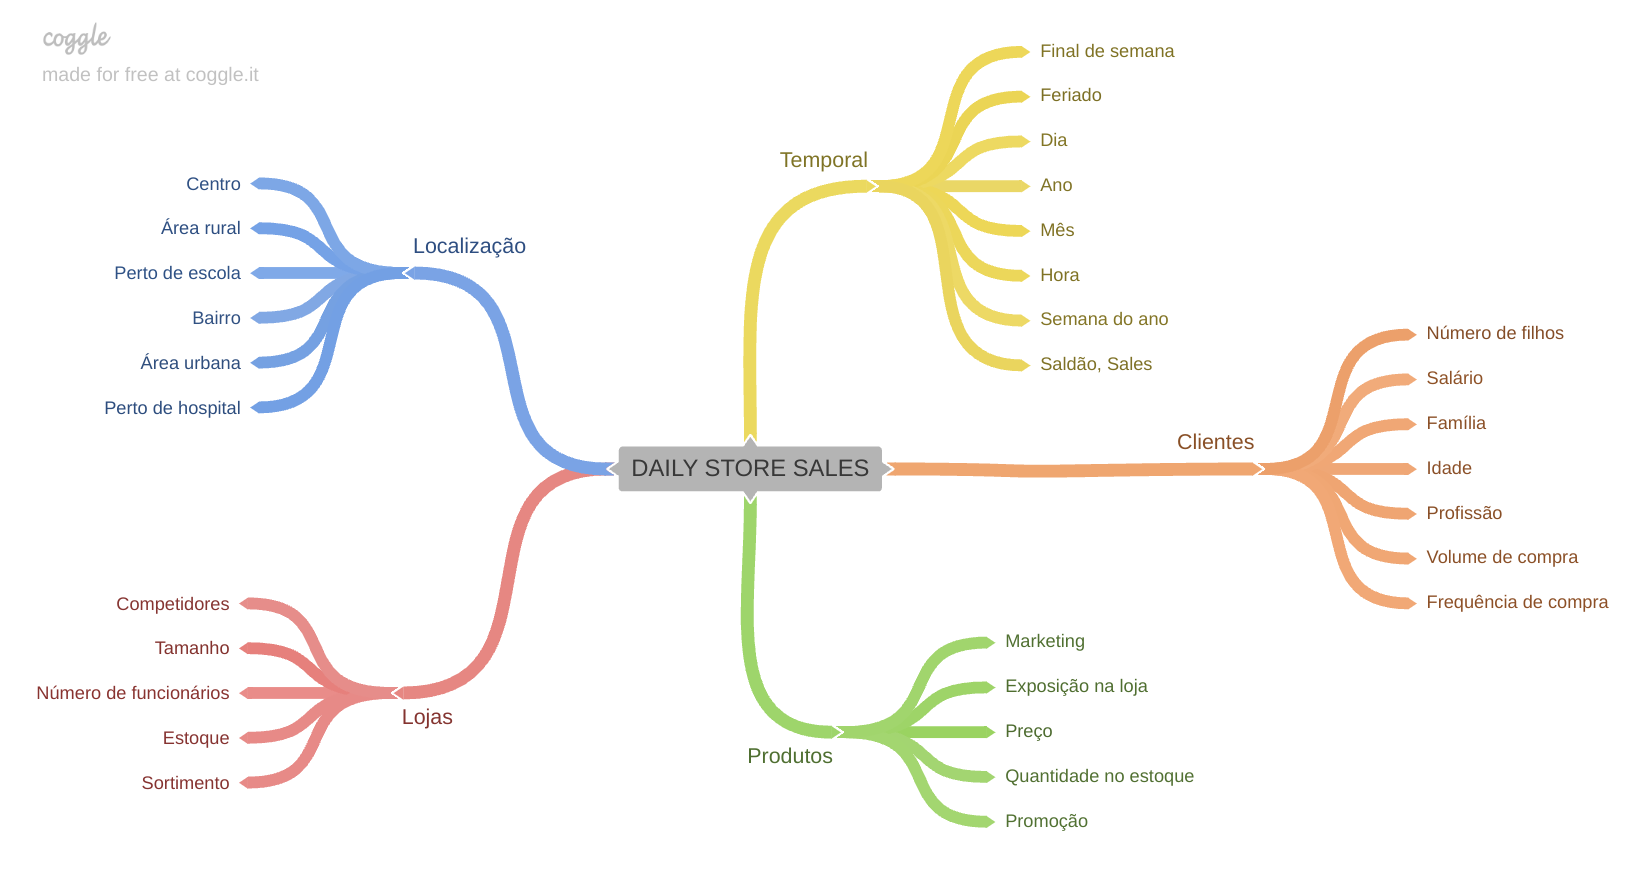

In [23]:
Image('img/MindmapHypothesis.png')

## 2.1. Criação das Hipóteses:

### 2.1.1 Hipóteses Loja

**1.** Lojas com maior quadro de funcionários deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com menor porte deveriam vender menos.

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores perto deveriam vender menos.

**7.** Lojas com competidores há mais tempo deveriam vender mais.

### 2.1.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores dos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores perto deveriam vender menos.

**3.** Lojas com competidores há mais tempo deveriam vender mais.

**4.** Lojas que tem promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [24]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [25]:
#competition since

df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)

df2['competition_since'] = (df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , 
                                                                  month = x['competition_open_since_month'] , day = 1), axis = 1))

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days = 7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply(lambda x: x.days ).astype( int )

In [26]:
#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = (df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' 
                                                     else 'easter_holiday' if x == 'b' 
                                                     else 'christmas' if x == 'c' 
                                                     else 'regular_day'))

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [28]:
df3 = df2.copy()

In [29]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das Linhas

In [30]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [31]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [32]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# PASSO 04 - ANÁLISE EXPLORATÓRIA DOS DADOS - EDA  

In [33]:
df4 = df3.copy()

## 4.1. Análise Univariada

### 4.1.1 Variável Resposta

<Axes: xlabel='sales', ylabel='Count'>

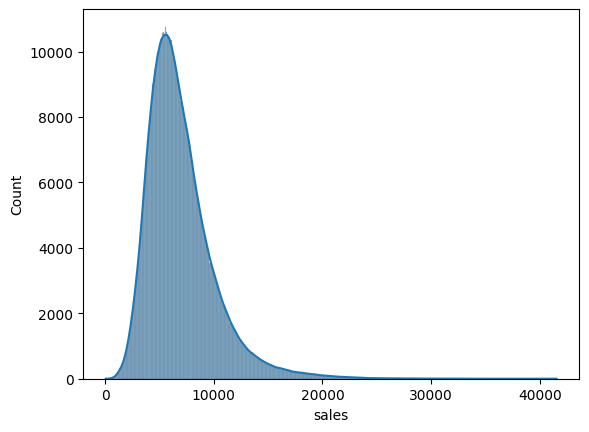

In [34]:
sns.histplot(df4['sales'], kde = True)

### 4.1.2 Variáveis Numéricas

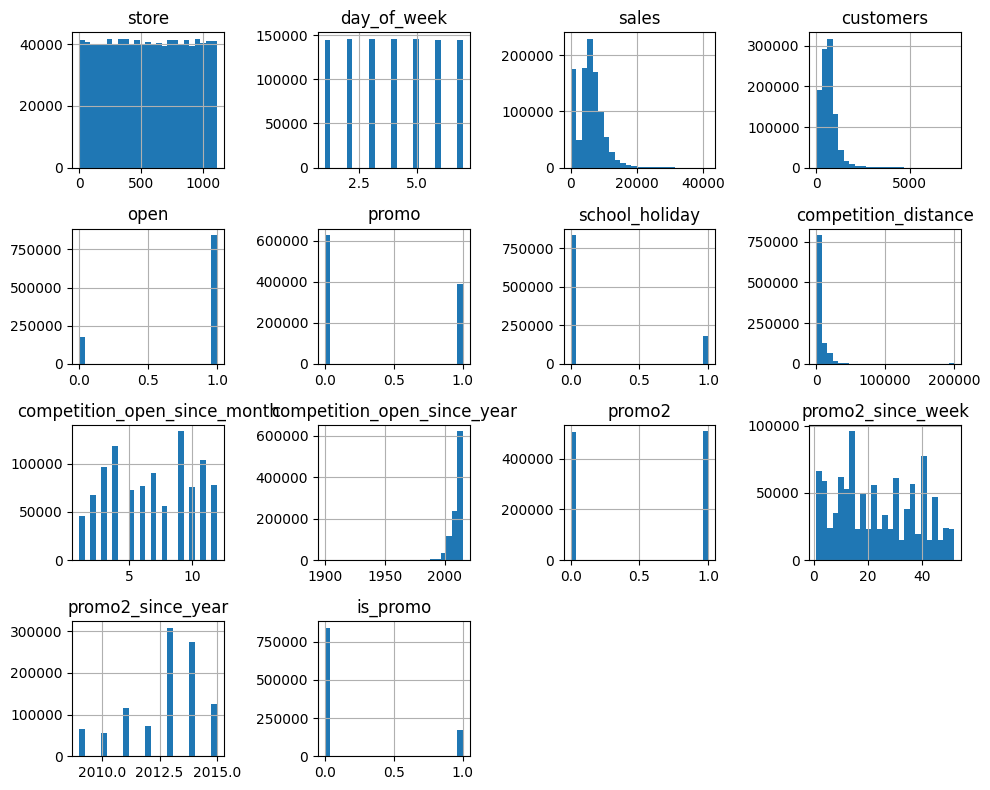

In [35]:
num_attributes.hist(bins=25, figsize=(10, 8))
plt.tight_layout()
plt.show()

### 4.1.3 Variáveis Categóricas

In [36]:
cat_attributes.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

In [37]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

In [38]:
df4['store_type'].unique()

array(['c', 'a', 'd', 'b'], dtype=object)

In [39]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

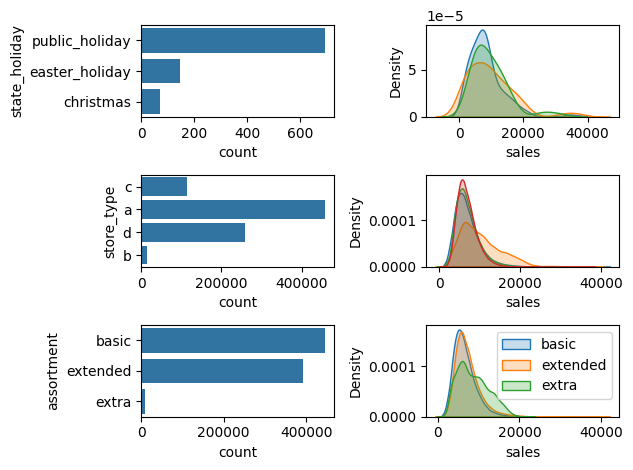

In [40]:
# state_holiday

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill = True)

# store_type

plt.subplot(3,2,3)

sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill = True)

# assortment

plt.subplot(3,2,5)

sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill = True)


plt.legend()
plt.tight_layout()
plt.show()

## 4.2. Análise Bivariada

### 4.2.1 Resumo das Hipóteses

In [126]:
tab = [['Hipoteses', 'Conclusão', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa'],
      ]

print(tabulate(tab, headers = 'firstrow'))     

Hipoteses    Conclusão    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


### **H1.** Lojas com maior sortimento deveriam vender mais.
**Conclusão**: H1 é **FALSA**. Lojas com MAIOR SORTIMENTO vendem MENOS.

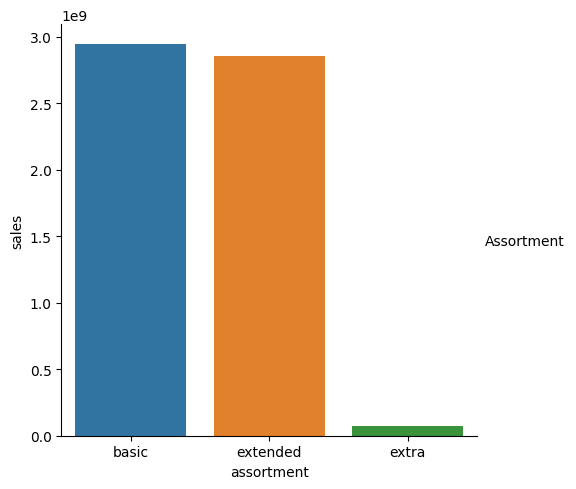

In [41]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

# Criar o gráfico de barras usando catplot
g = sns.catplot(x='assortment', y='sales', hue='assortment', data=aux1, kind='bar', legend=False)

# Ajustar a posição da legenda
g.add_legend(title='Assortment')

# Mostrar o gráfico
plt.show()

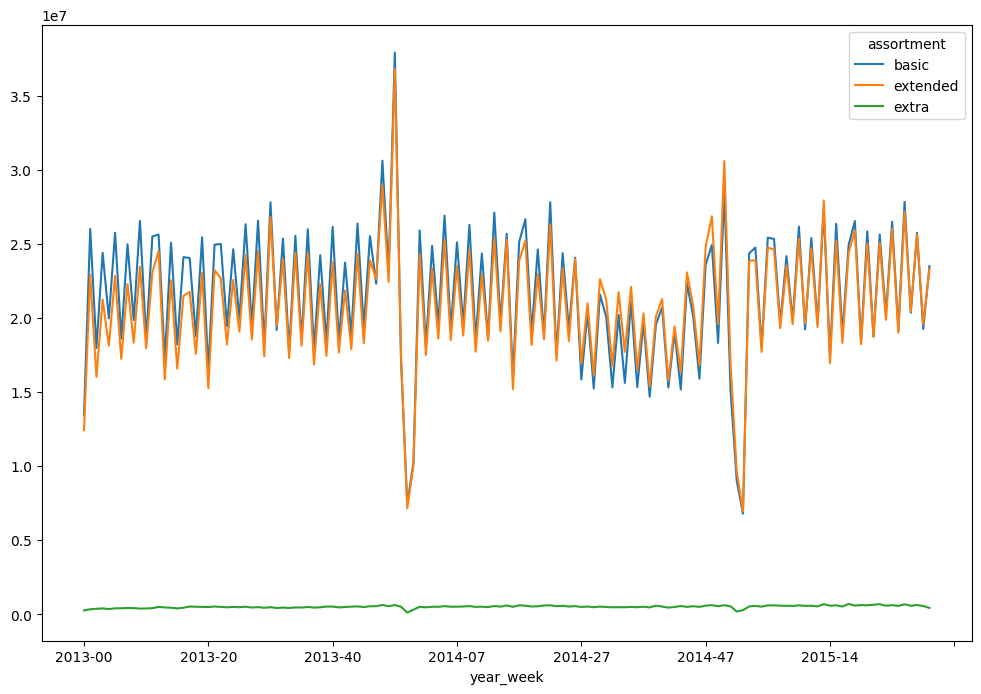

In [42]:
aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize = (12,8)) 
#index = granularidade das linhas
plt.show()

<Axes: xlabel='year_week'>

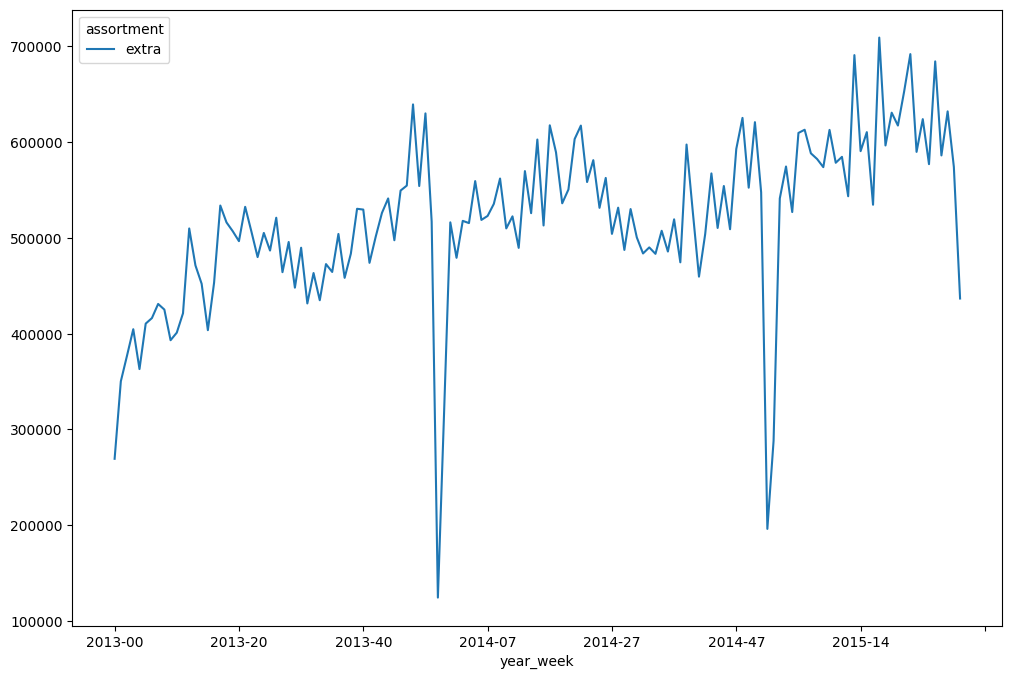

In [43]:
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot(figsize = (12,8))

### **H2.** Lojas com competidores perto deveriam vender menos.
**Conclusão:** H2 é **FALSA**. Lojas com MAIS COMPETIDORES PERTO vendem MAIS.

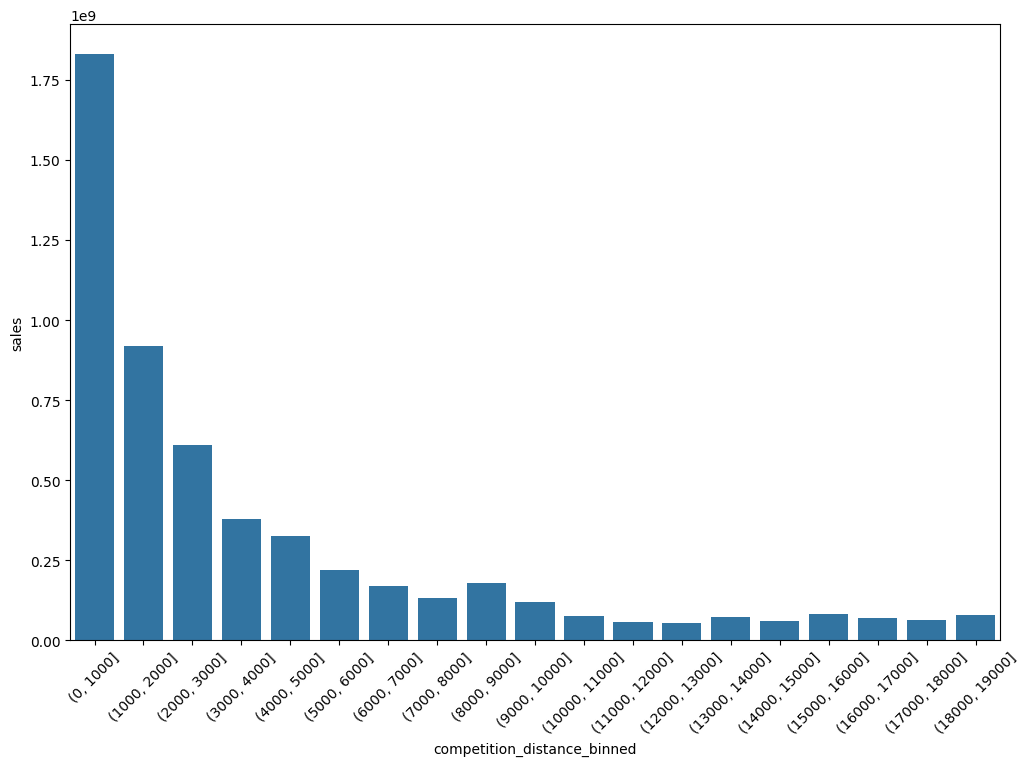

In [44]:
h2_aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

#criando os bins com uma lista que vai de 0 a 20.000, com grupos de 1.000 em 1.000:
bins = list(np.arange(0, 20000, 1000))

#criando nova coluna:
h2_aux1['competition_distance_binned'] = pd.cut(h2_aux1['competition_distance'], bins = bins)

h2_aux2 = h2_aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

#plotando o gráfico:
plt.figure(figsize=(12, 8))
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = h2_aux2)
plt.xticks(rotation=45)
plt.show();

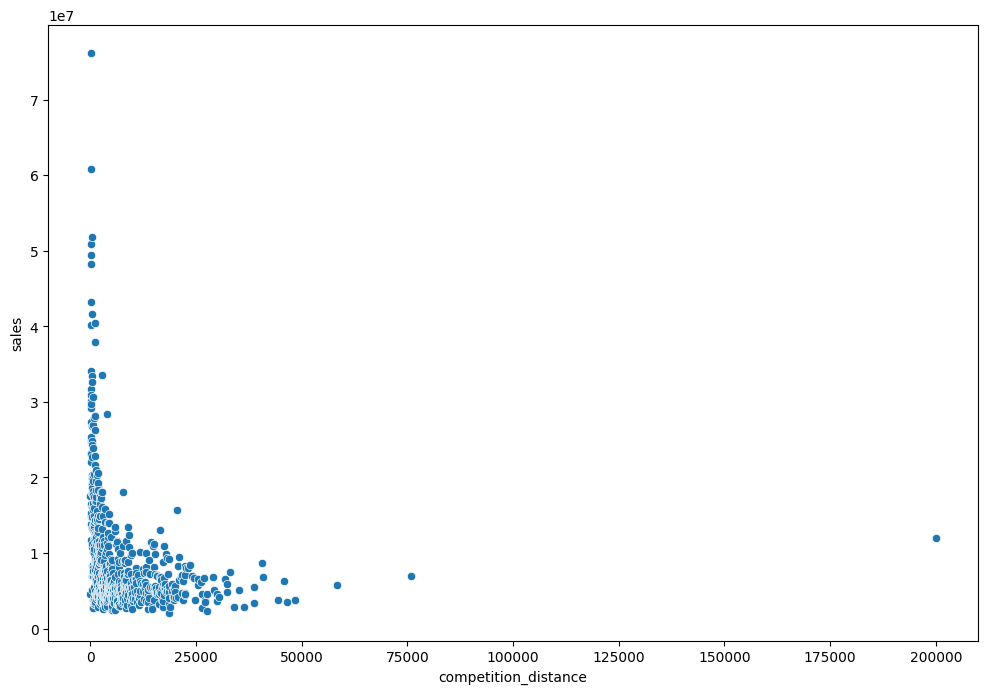

In [45]:
#para dados com muita granularidade, uma boa opção é o Scatterplot (gráfico de dispersão:

plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'competition_distance', y = 'sales', data = h2_aux1)
plt.show();

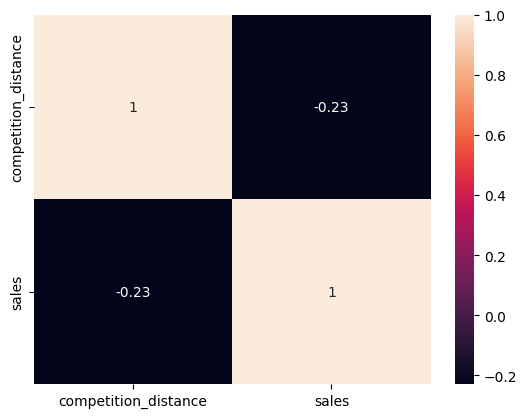

In [46]:
#heatmap, gráfico de correlação:

# Calculando correlação apenas para colunas numéricas
corr_matrix = h2_aux1.select_dtypes(include='number').corr(method='pearson')

# Criando o heatmap
sns.heatmap(corr_matrix, annot=True)

# Mostrando o gráfico
plt.show()

### **H3.** Lojas com competidores há mais tempo deveriam vender mais.
**Conclusão:** H3 é **FALSA**. Lojas com competidores há mais tempo vendem MENOS.

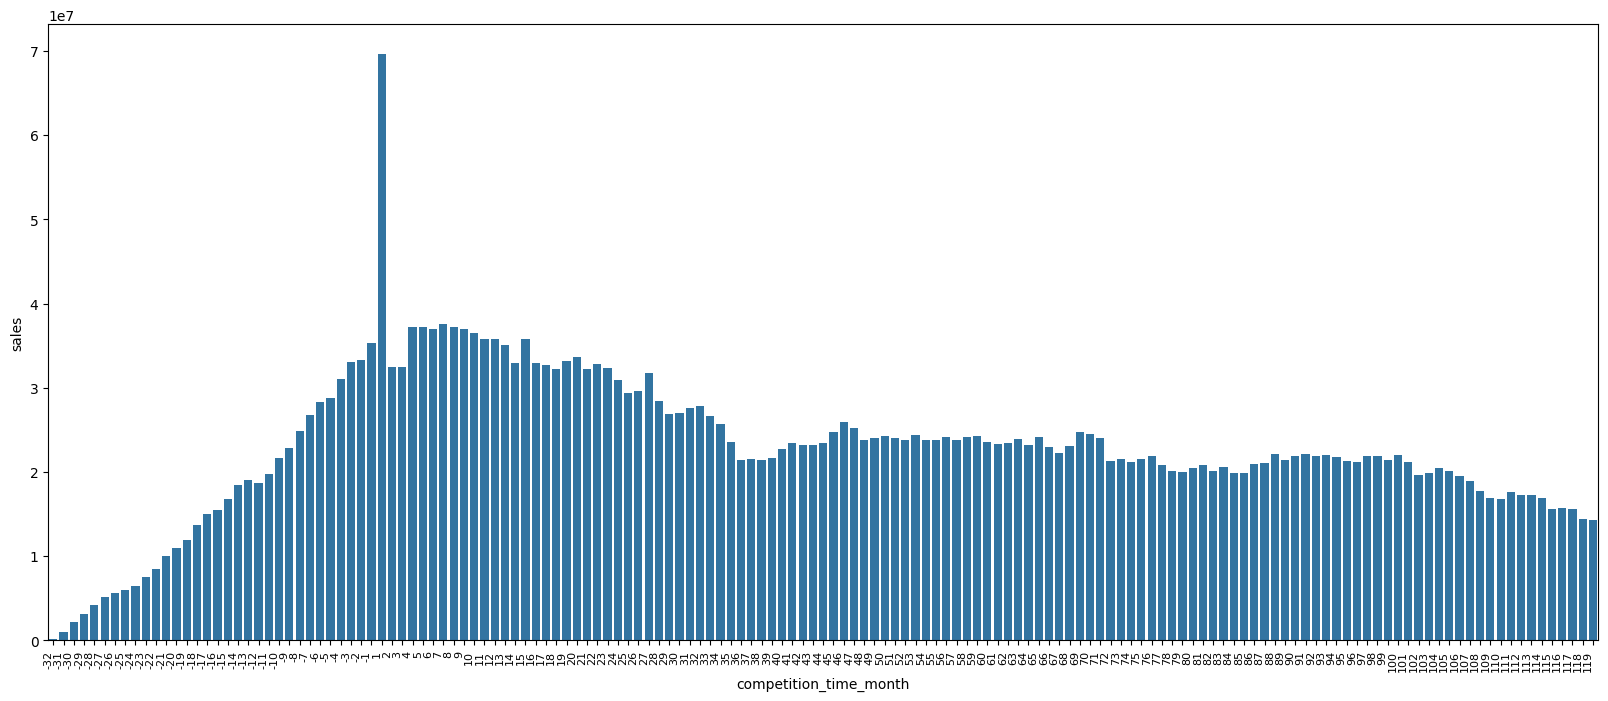

In [47]:
h3 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
h3_aux2 = h3[(h3['competition_time_month'] < 120) & (h3['competition_time_month'] != 0)]

plt.figure(figsize=(20, 8))
sns.barplot(x = 'competition_time_month', y = 'sales', data = h3_aux2)
plt.xticks(rotation=90, ha='right', fontsize = 8)
plt.show();

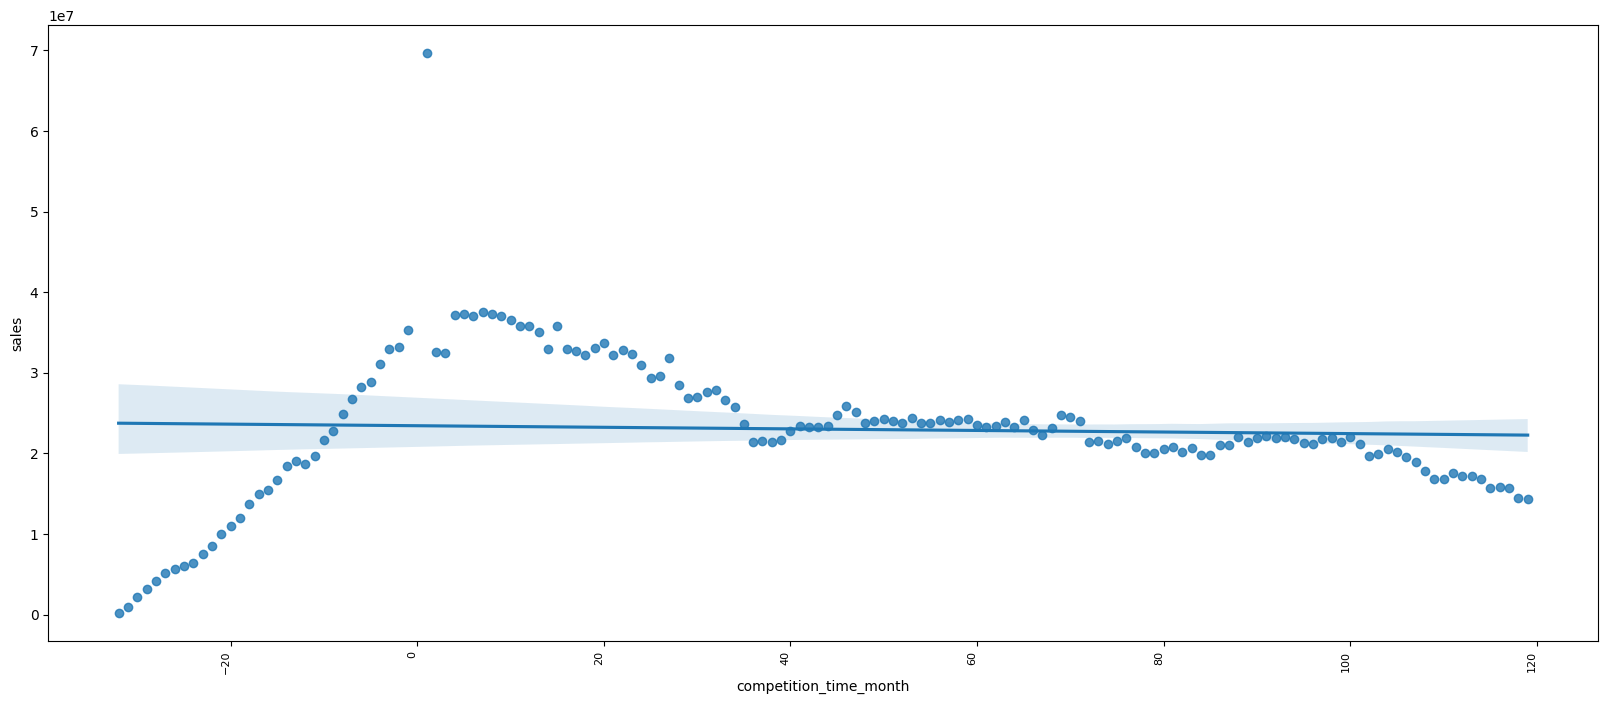

In [48]:
#gráfico de tendência:

plt.figure(figsize=(20, 8))
sns.regplot(x = 'competition_time_month', y = 'sales', data = h3_aux2)
plt.xticks(rotation=90, ha='right', fontsize = 8)
plt.show();

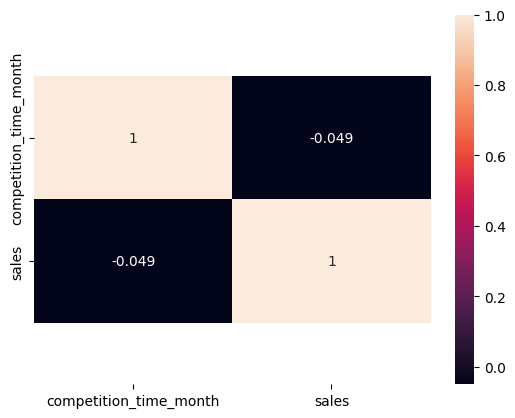

In [49]:
x = sns.heatmap(h3_aux2.corr(method = 'pearson'), annot = True);
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

### **H4.** Lojas que tem promoções ativas por mais tempo deveriam vender mais.
**Conclusão**: H4 é **FALSA**. Lojas com promoções ativas por mais tempo vendem MENOS depois de um certo tempo.

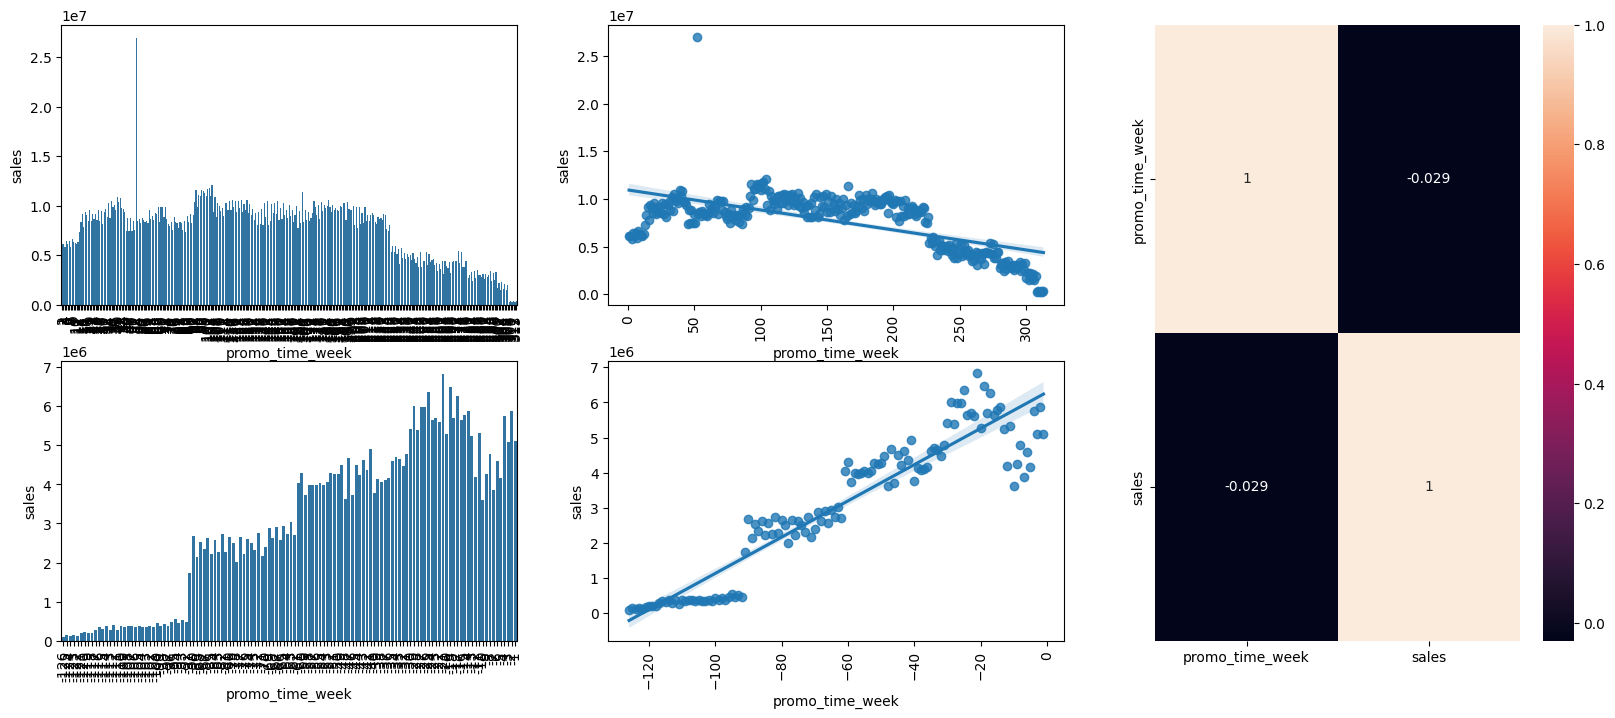

In [50]:
h4 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(20, 8));

grid = plt.GridSpec(2,3)

plt.subplot(grid[0,0])
h4_aux2 = h4[h4['promo_time_week'] > 0] #promoção extendida
sns.barplot(x ='promo_time_week', y = 'sales', data = h4_aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
h4_aux2 = h4[h4['promo_time_week'] > 0] #promoção extendida
sns.regplot(x ='promo_time_week', y = 'sales', data = h4_aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[1,0])
h4_aux3 = h4[h4['promo_time_week'] < 0] #promoção regular
sns.barplot(x ='promo_time_week', y = 'sales', data = h4_aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
h4_aux3 = h4[h4['promo_time_week'] < 0] #promoção regular
sns.regplot(x ='promo_time_week', y = 'sales', data = h4_aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
sns.heatmap(h4.corr(method = 'pearson'), annot = True);

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>
**OBS:** Será testada no próximo CRISP-DS

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Conclusão**: H6 é **FALSA**. Lojas com mais promoções consecutivas vendem MENOS.

In [53]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().sort_values('sales').reset_index()

,promo,promo2,sales
0,0,1,1289362241
1,1,1,1472275754
2,0,0,1482612096
3,1,0,1628930532


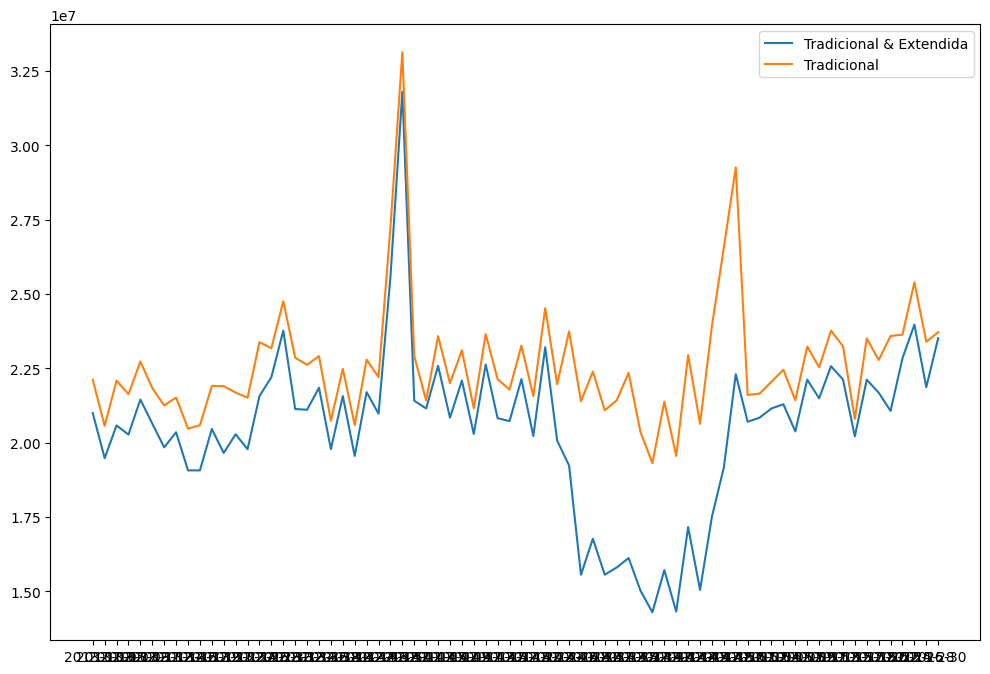

In [94]:
h6 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)].groupby('year_week')[['sales']].sum().reset_index()
h6_aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)].groupby('year_week')[['sales']].sum().reset_index()

# Tamanho do gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Plotagem do primeiro conjunto de dados
ax.plot(h6['year_week'], h6['sales'], label='Tradicional & Extendida')

# Plotagem do segundo conjunto de dados
ax.plot(h6_aux2['year_week'], h6_aux2['sales'], label='Tradicional')

# Adição da legenda
ax.legend()

# Mostre o gráfico
plt.show()

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Conclusão**: H7 é **FALSA**. O Natal é o feriado que vende MENOS.

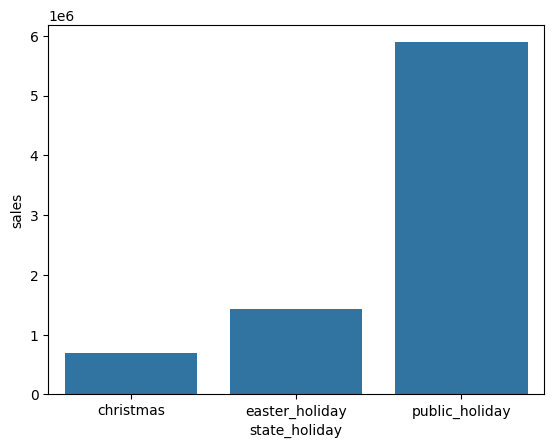

In [97]:
feriados = df4[df4['state_holiday'] != 'regular_day']
h7 = feriados[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x = 'state_holiday', y = 'sales', data = h7);

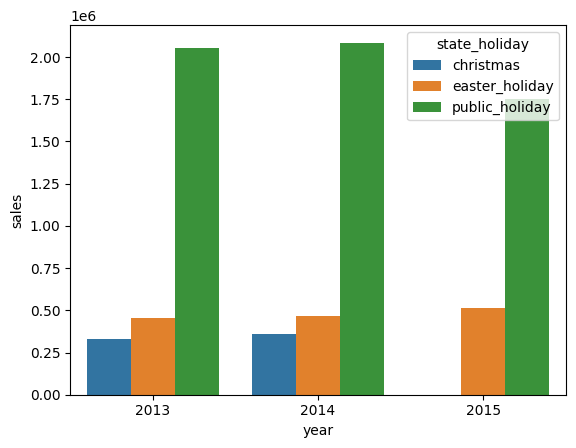

In [99]:
#Quanto foi vendido no Natal ao longo do tempo?

h7_aux2 = feriados[['year', 'state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y = 'sales', hue = 'state_holiday', data = h7_aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Conclusão**: H8 é **FALSA**. As vendas estão caindo ao longo dos anos.

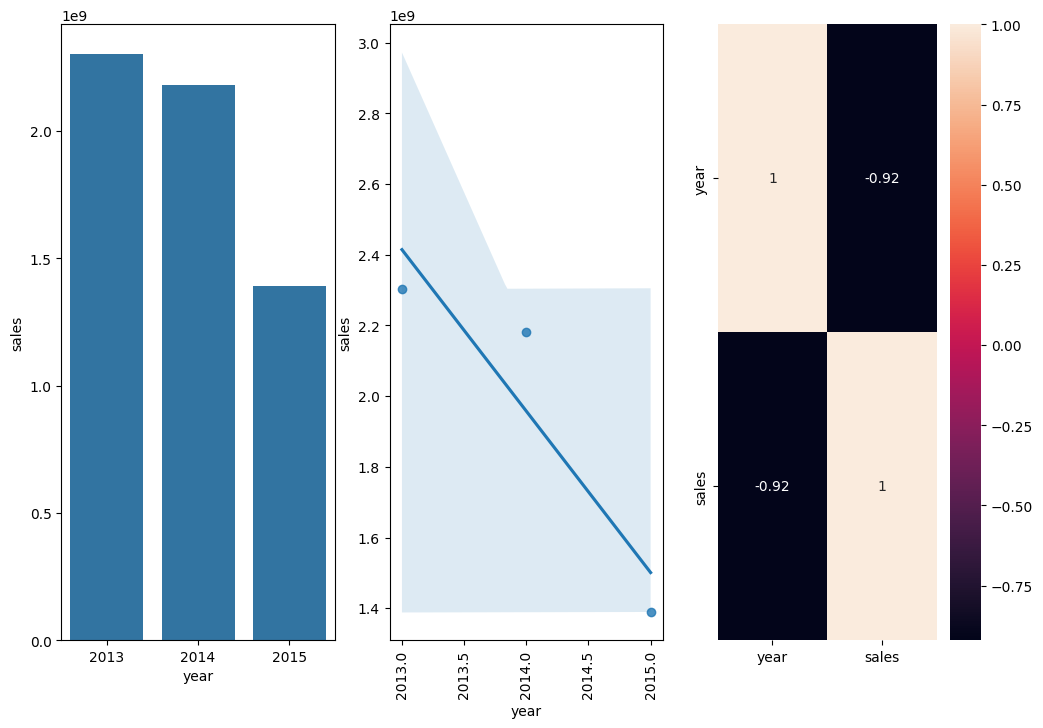

In [107]:
#separando os dados, vendas por ano:
h8 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(12,8));

#gráfico de barras
plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data =h8);

#calculando a tendência:
plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data =h8);
plt.xticks(rotation = 90);

#força da correlação:
plt.subplot(1,3,3)
sns.heatmap(h8.corr(method = 'pearson'), annot = True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Conclusão**: H9 é **FALSA**. Lojas vendem MENOS no segundo semestre do ano.

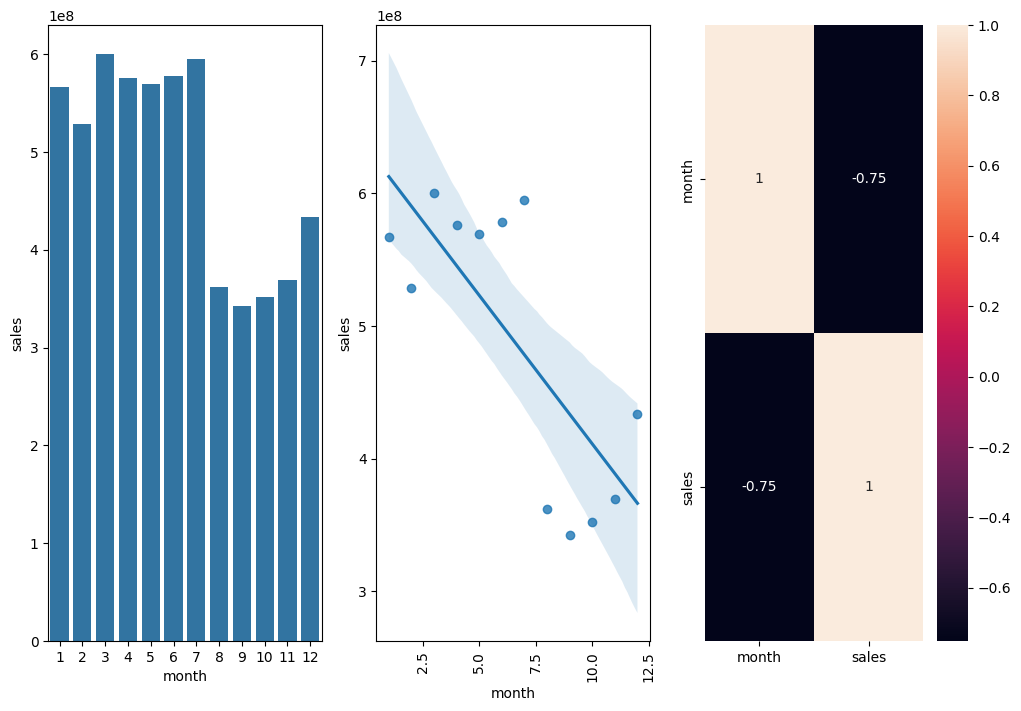

In [108]:
#separando os dados, vendas por ano:
h9 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(12,8));

#gráfico de barras
plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = h9);

#calculando a tendência:
plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = h9);
plt.xticks(rotation = 90);

#força da correlação:
plt.subplot(1,3,3)
sns.heatmap(h9.corr(method = 'pearson'), annot = True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Conclusão:** H10 é **VERDADEIRA**. Lojas vendem MAIS depois do dia 10 de cada mês.

C:\Users\samso\AppData\Local\Temp\ipykernel_15180\2753458347.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(h10.corr(method = 'pearson'), annot = True);


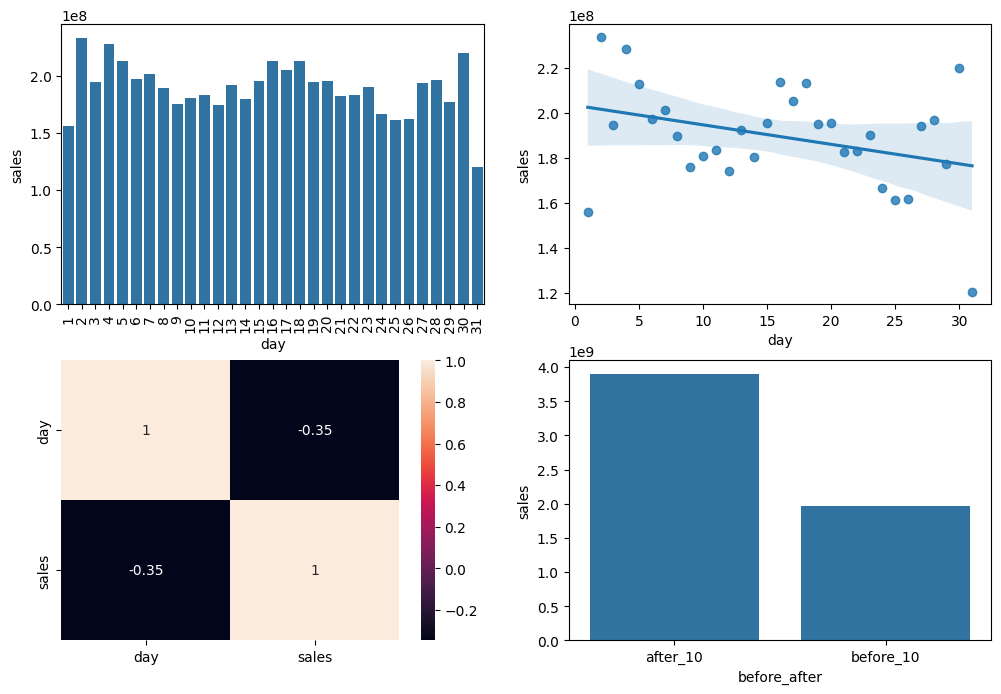

In [116]:
#separando os dados, vendas por dia:
h10 = df4[['day', 'sales']].groupby('day').sum().reset_index()

#vendas antes e depois do dia 10:
h10['before_after'] = h10['day'].apply(lambda x: 'before_10' if x <= 10 else 'after_10')
h10_aux2 = h10[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.figure(figsize=(12,8));

#gráfico de barras
plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = h10);
plt.xticks(rotation = 90);

#calculando a tendência:
plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = h10);

#força da correlação:
plt.subplot(2,2,3)
sns.heatmap(h10.corr(method = 'pearson'), annot = True);

#antes e depois do dia 10:
plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y = 'sales', data = h10_aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**Conclusão**: H11 é **VERDADEIRA**. Lojas vendem MENOS nos finais de semana.

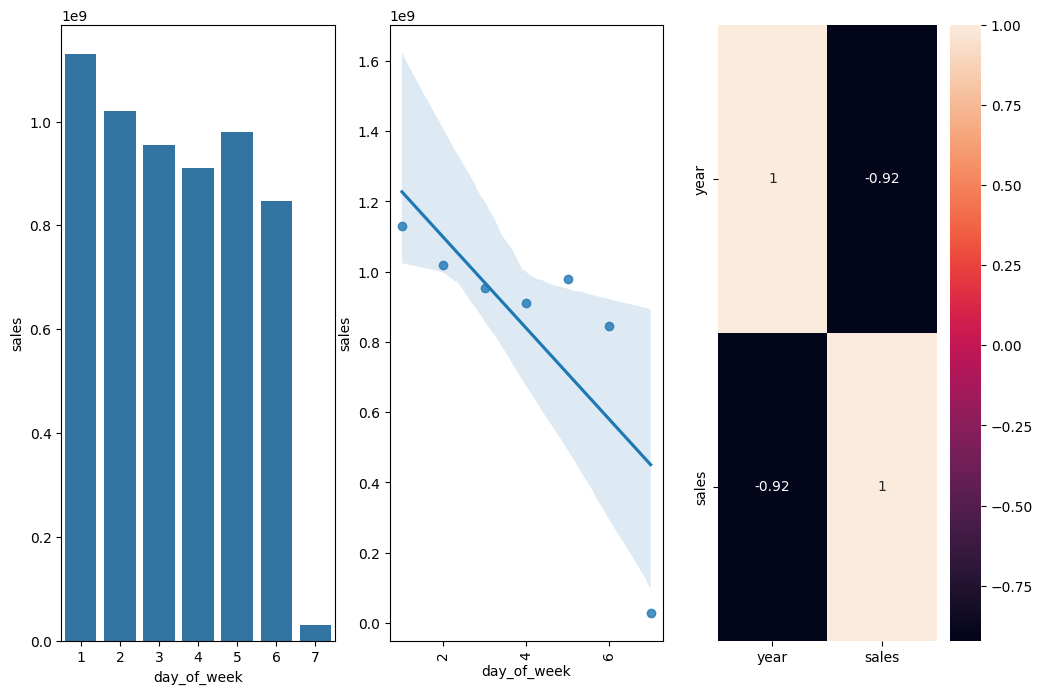

In [117]:
#separando os dados, vendas por ano:
h11 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(12,8));

#gráfico de barras
plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = h11);

#calculando a tendência:
plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = h11);
plt.xticks(rotation = 90);

#força da correlação:
plt.subplot(1,3,3)
sns.heatmap(h8.corr(method = 'pearson'), annot = True);

### **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Conclusão:** H2 é **VERDADEIRA**. Lojas vendem MENOS durante os feriados escolares, exceto em agosto.

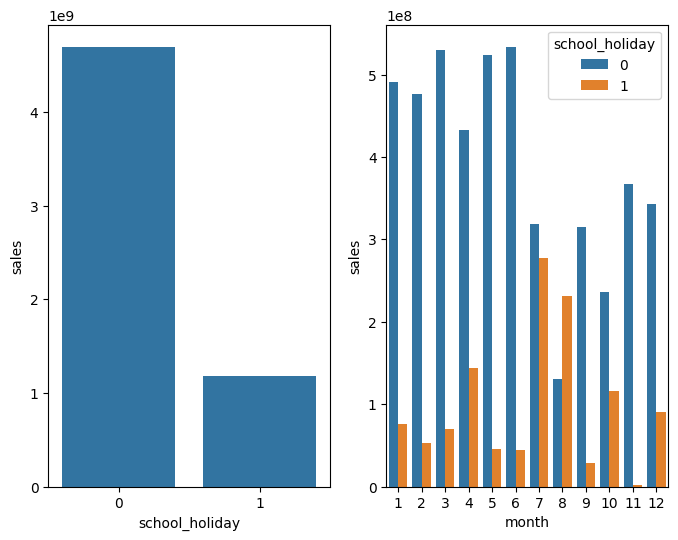

In [121]:
h12 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
h12_aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.figure(figsize=(8,6));

plt.subplot(1,2,1)
sns.barplot( x = 'school_holiday', y = 'sales', data = h12);

plt.subplot(1,2,2)
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = h12_aux2);

## 4.3. Análise Multivariada

### 4.3.1 Numerical Attributes

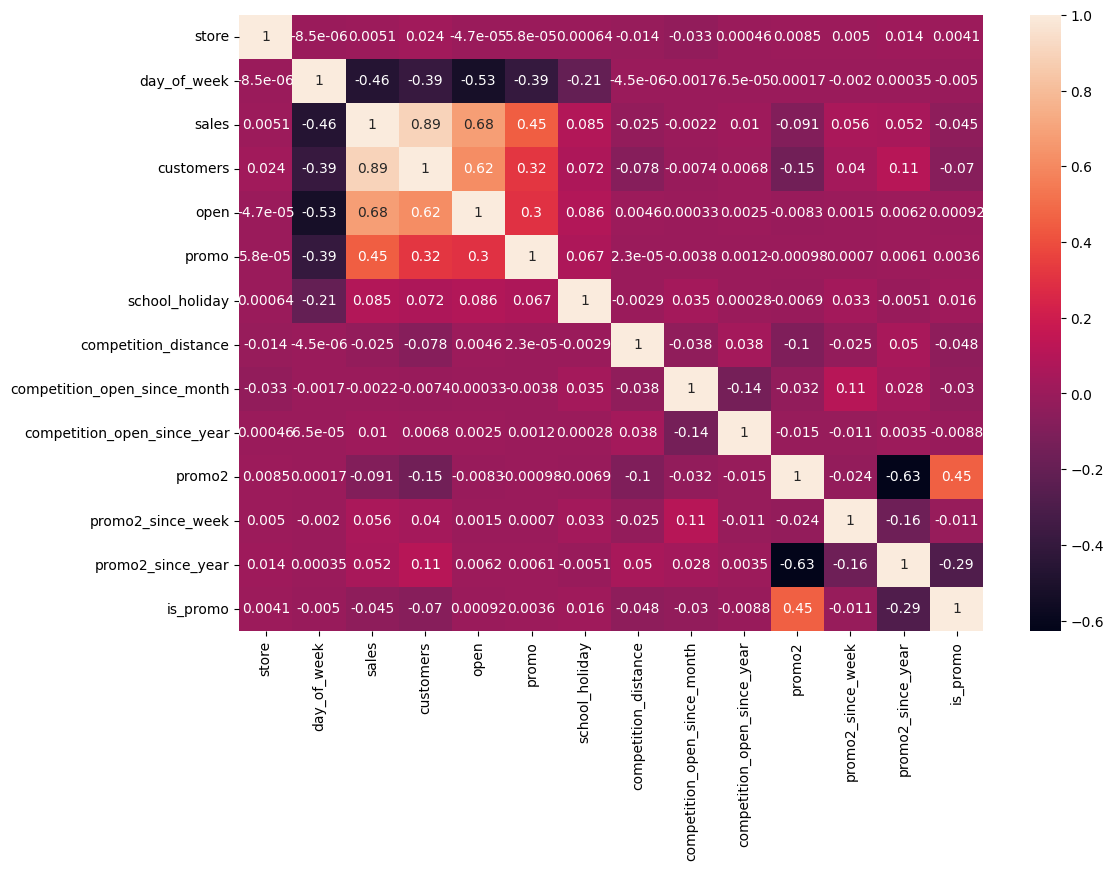

In [131]:
correlation = num_attributes.corr(method = 'pearson')

plt.figure(figsize=(12,8));
sns.heatmap(correlation, annot = True);

### 4.3.2 Categorical Attributes

In [132]:
a = df4.select_dtypes(include = 'object') #só as colunas categóricas

In [157]:
#calculando o V de Cramer

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

#Dataframe final

d  = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] } )

d = d.set_index( d.columns )

<Axes: >

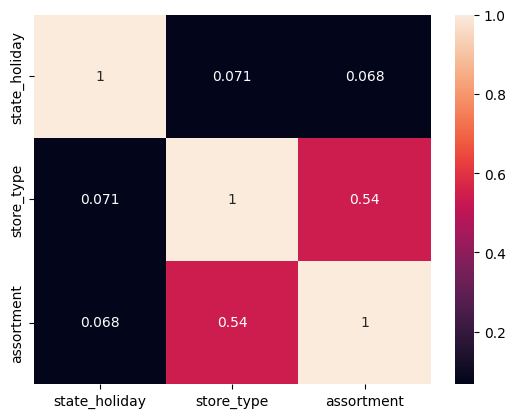

In [159]:
sns.heatmap(d , annot = True)